In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from folium.plugins import HeatMap

import funcoes

In [2]:
parcial_path_absolute = Path.home() / 'OneDrive' / 'Documentos' / 'GitHub'
parcial_path_relative = Path('analise_dados_crimes_seattle')
full_path = parcial_path_absolute / parcial_path_relative

absolute_path_data_raw = full_path / 'data' / 'raw'
absolute_path_data_processed = full_path / 'data' / 'processed'

path_data = absolute_path_data_processed / 'SPD_Crime_data_cleaned.csv'

path_data_split_one = absolute_path_data_processed / 'split_SPD_Crime_data_cleaned_1.csv'
path_data_split_two = absolute_path_data_processed / 'split_SPD_Crime_data_cleaned_2.csv'
path_data_split_three = absolute_path_data_processed / 'split_SPD_Crime_data_cleaned_3.csv'

path_data_population = absolute_path_data_raw / 'population.xlsx'

In [3]:
df_population = pd.read_excel(path_data_population)

In [4]:
px.line(df_population, x='year', y='population')

In [5]:
# selecionar dados de 2017 até 2024 => tamanho da população com variação de aproximadamente 3,5%

In [6]:
df = pd.read_csv(path_data)
dff = df.copy()

In [7]:
dff_split_one = pd.read_csv(path_data_split_one)
dff_split_two = pd.read_csv(path_data_split_two)
dff_split_three = pd.read_csv(path_data_split_three)

dff_split = pd.concat([dff_split_one, dff_split_two, dff_split_three])

In [9]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398740 entries, 0 to 1398739
Data columns (total 16 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   report number                   1398740 non-null  object 
 1   report datetime                 1398740 non-null  object 
 2   offense id                      1398740 non-null  int64  
 3   offense date                    1398740 non-null  object 
 4   nibrs group ab                  1398740 non-null  object 
 5   nibrs crime against category    1398740 non-null  object 
 6   offense sub category            1398740 non-null  object 
 7   shooting type group             1398740 non-null  object 
 8   beat                            1398740 non-null  object 
 9   precinct                        1398740 non-null  object 
 10  sector                          1398740 non-null  object 
 11  offense category                1398740 non-null  object 
 12  

In [7]:
# 'report datetime'
dff['report datetime'] = funcoes.transformando_colunas_em_datetime(dff, 'report datetime')

# 'offense date
dff['offense date'] = funcoes.transformando_colunas_em_datetime(dff, 'offense date')

c:\Users\tales\OneDrive\Documentos\GitHub\analise_dados_crimes_seattle\src\funcoes\__init__.py:8: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

c:\Users\tales\OneDrive\Documentos\GitHub\analise_dados_crimes_seattle\src\funcoes\__init__.py:8: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [8]:
dff['hour'] = dff['offense date'].apply(lambda x: x.hour)
dff['minute'] = dff['offense date'].apply(lambda x: x.minute)
dff['day_of_week'] = dff['offense date'].apply(lambda x: x.day_of_week)
dff['month'] = dff['offense date'].apply(lambda x: x.month)
dff['year'] = dff['offense date'].apply(lambda x: x.year)

# Definindo a função para categorizar os períodos do dia
def categorizar_periodo(hora):
    if 0 <= hora < 6:
        return 'Madrugada (0-6h)'
    elif 6 <= hora < 12:
        return 'Manhã (6-12h)'
    elif 12 <= hora < 18:
        return 'Tarde (12-18h)'
    else:
        return 'Noite (18-24h)'


# Aplicando a função à coluna 'hour'
dff['periodo'] = dff['hour'].apply(categorizar_periodo)

dff['day_type'] = dff['day_of_week'].apply(lambda x: 'weekend' if x >= 4 else 'business day')

In [139]:
dff_eda = dff.copy()

In [140]:
# filtrando ano
dff_eda = dff_eda[(dff_eda['year']>=2017) & (dff_eda['year']<2025)]

In [141]:
dff_eda.head(1)

,report number,report datetime,offense id,offense date,nibrs group ab,nibrs crime against category,offense sub category,shooting type group,beat,precinct,...,nibrs_offense_code,longitude,latitude,hour,minute,day_of_week,month,year,periodo,day_type
6,2022-018278,2022-01-22 21:12:40,31345377632,2022-01-22 19:20:00,B,SOCIETY,TRESPASS,-,Q3,West,...,90J,0.0,0.0,19,20,5,1,2022,Noite (18-24h),weekend


In [142]:
dff_eda.columns

Index(['report number', 'report datetime', 'offense id', 'offense date',
       'nibrs group ab', 'nibrs crime against category',
       'offense sub category', 'shooting type group', 'beat', 'precinct',
       'sector', 'offense category', 'nibrs offense code description',
       'nibrs_offense_code', 'longitude', 'latitude', 'hour', 'minute',
       'day_of_week', 'month', 'year', 'periodo', 'day_type'],
      dtype='object')

## Análise Exploratória (EDA)

### Estatística Descritiva

#### Frequência de tipos de crimes

In [143]:
# contagem por nibrs group ab
dff_eda['nibrs group ab'].value_counts(normalize=True)

nibrs group ab
A    0.864848
B    0.135152
Name: proportion, dtype: float64

In [144]:
# 86.48% | Grupo A: inclui crimes mais graves
# 13.51% | Grupo B: inclui infrações de menor gravidade

In [145]:
# contagem por nibrs crime against category
dff_eda['nibrs crime against category'].value_counts(normalize=True)

nibrs crime against category
PROPERTY    0.678047
PERSON      0.161027
SOCIETY     0.084182
ANY         0.076744
Name: proportion, dtype: float64

In [146]:
# PROPERTY: Cerca de 67,8% dos registros são crimes contra a propriedade (por exemplo, furto, roubo, arrombamento, vandalismo, etc.).
# PERSON: Aproximadamente 16,1% são crimes contra a pessoa (por exemplo, agressão, homicídio, estupro).
# SOCIETY: Cerca de 8,4% são crimes contra a sociedade (por exemplo, porte ilegal de arma, drogas, prostituição, crimes ambientais).
# ANY: Cerca de 7,6% foram classificados como “ANY” (pode ser um rótulo genérico ou casos em que o sistema não conseguiu classificar de forma mais específica).

## insights iniciais
# Prioridades de policiamento: Se quase 70% dos registros são crimes contra propriedade, políticas de prevenção (iluminação, policiamento ostensivo em áreas de furtos/roubos, conscientização sobre proteção de veículos e imóveis) podem ser reforçadas.
# Alocação de recursos: A parcela expressiva de crimes contra a pessoa (16%) demanda estratégias específicas (por exemplo, patrulhas em horários de maior incidência, programas de redução de violência doméstica, acompanhamento de reincidentes).
# Políticas de controle social: Parte dos crimes contra a sociedade (8,4%) pode exigir abordagens diferentes, como combate ao tráfico de drogas, medidas educativas ou mudanças na legislação local.

In [147]:
# contagem por nibrs crime against category
dff_eda['offense sub category'].value_counts(normalize=True).head(10)

offense sub category
LARCENY-THEFT                                            0.320877
BURGLARY                                                 0.108602
ASSAULT OFFENSES                                         0.096970
PROPERTY OFFENSES (INCLUDES STOLEN, DESTRUCTION)         0.093090
ALL OTHER                                                0.076744
MOTOR VEHICLE THEFT                                      0.071454
EXTORTION/FRAUD/FORGERY/BRIBERY (INCLUDES BAD CHECKS)    0.061566
AGGRAVATED ASSAULT                                       0.037506
TRESPASS                                                 0.034154
ROBBERY                                                  0.020478
Name: proportion, dtype: float64

In [148]:
# ~43% dos crimes se dividem em LARCENY-THEFT (32.1%) e BURGLARY (10.8%)

# LARCENY-THEFT: corresponde a quase 1/3 de todos os registros. Isso reforça a ideia de que crimes contra a propriedade são comuns no dataset. 
## Inclui crimes de furto, geralmente sem uso de força ou violência direta contra a vítima (por exemplo, furtos em lojas, roubos de objetos em veículos destrancados, etc.).

# BURGLARY: corresponde a quase 11% dos casos, envolvendo invasão de imóveis (residências, estabelecimentos) para cometer furto ou outro delito. 
## Também se enquadra em crimes contra a propriedade

In [149]:
# verificando crimes "ALL OTHER"
dff_eda[dff_eda['offense sub category']=='ALL OTHER']['nibrs group ab'].value_counts()

nibrs group ab
B    49657
Name: count, dtype: int64

In [150]:
dff_eda[dff_eda['offense sub category']=='ALL OTHER']['nibrs crime against category'].value_counts()

nibrs crime against category
ANY    49657
Name: count, dtype: int64

In [151]:
dff_eda = dff_eda[dff_eda['offense sub category']!='ALL OTHER']

In [152]:
# Descartar já que não existe informação nenhuma sobre os crimes e todos eles se encaixam no grupo de menor gravidade (B)

#### Distribuição por dia da semana, mês, hora do dia

<Axes: >

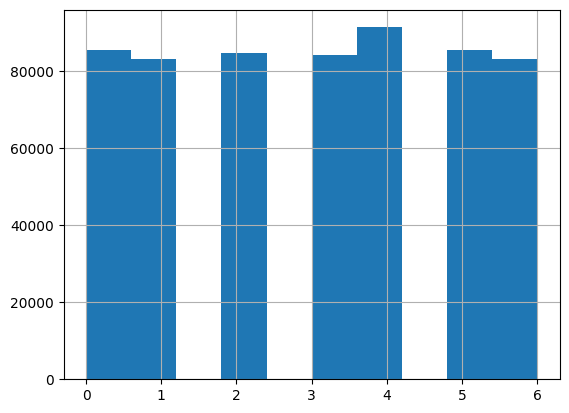

In [153]:
# dia da semana
dff_eda['day_of_week'].hist()

In [154]:
# distribuição ilustra que não temos muita variação por dia da semana

In [155]:
# mês
dff_eda['month'].value_counts(normalize=True)

month
5     0.093761
10    0.087926
8     0.087651
7     0.086913
9     0.084441
1     0.082962
3     0.082112
12    0.081617
11    0.081561
4     0.079827
6     0.079067
2     0.072162
Name: proportion, dtype: float64

In [156]:
px.bar(dff_eda.groupby('month').agg({'offense id':'count'}).reset_index(), x='month', y='offense id')

In [157]:
# hora do dia
dff_eda['hour'].value_counts(normalize=True)

hour
0     0.103683
12    0.054924
17    0.053568
18    0.053277
20    0.052135
19    0.049032
22    0.048580
16    0.047990
21    0.047805
15    0.046171
14    0.042063
23    0.041862
13    0.040804
11    0.037468
10    0.035891
8     0.034483
1     0.034140
9     0.033852
2     0.028328
7     0.024841
3     0.024383
4     0.022769
6     0.021455
5     0.020497
Name: proportion, dtype: float64

In [158]:
# identificação de outliers, possíveis erros em dados
dff_eda = dff_eda[(dff_eda['hour']!=0) & (dff_eda['minute']!=0)]

In [159]:
dff_eda['hour'].value_counts(normalize=True)

hour
16    0.056154
17    0.056083
15    0.054799
18    0.054430
20    0.053982
19    0.053145
12    0.052542
14    0.052129
13    0.051457
21    0.050631
11    0.047281
22    0.047131
23    0.044931
10    0.041914
9     0.038351
1     0.037894
8     0.036170
2     0.033014
7     0.030215
3     0.028518
4     0.028259
6     0.025493
5     0.025477
Name: proportion, dtype: float64

In [160]:
px.bar(dff_eda.groupby('periodo').agg({'offense id':'count'}).reset_index(), x='periodo', y='offense id')

In [161]:
# a maior parte dos crimes ocorrem entre 12h - 24h
# no período da "madrugada" temos um número menor de reports, sugerindo que a força policiar deve ser priorizada para os horários de 12h em diante.

#### Tendências de aumento ou diminuição ao longo do tempo.

In [162]:
dff_por_cem_mil = pd.merge((dff.groupby('year').agg({'offense id':'count'}).reset_index()), (df_population), how='left', on='year')
dff_por_cem_mil = dff_por_cem_mil[dff_por_cem_mil['year']>=2008]
dff_por_cem_mil['taxa'] = round(((dff_por_cem_mil['offense id'] / dff_por_cem_mil['population']) * 100000), 2)
px.line(dff_por_cem_mil, x='year', y='taxa')

In [163]:
# de 2008 tendência geral de queda na taxa (/100mil) de crimes na cidade de Seattle.

In [164]:
dff_por_cem_mil = pd.merge((dff_eda.groupby('year').agg({'offense id':'count'}).reset_index()), (df_population), how='left', on='year')
dff_por_cem_mil['taxa'] = round(((dff_por_cem_mil['offense id'] / dff_por_cem_mil['population']) * 100000), 2)
px.line(dff_por_cem_mil, x='year', y='taxa')

In [165]:
# para um período mais recente (população constante) tendência de queda com instabilidade entre 2020 - 2022
# pandemia pode ter impacto para a interferência na tendência de queda?

### Visualizações

#### Gráficos de linhas para evoluções temporais

In [166]:
px.line(funcoes.df_filtrado_taxa_cem_mil(dff[(dff['year']>=2008) & (dff['year']<2025)], df_population, 'nibrs crime against category', 'PROPERTY'), x='year', y='taxa')

In [167]:
# Para crimes cometidos contra a propriedade observa-se comportamento semelhante aos dados completos porém de uma forma mais agressiva;
# tendência geral histórica de queda (2014-2019) com forte mudança de comportamento no período entre 2019-2022 (pandemia), voltando a estabilizar a queda após 2022.

In [168]:
px.line(funcoes.df_filtrado_taxa_cem_mil(dff[(dff['year']>=2008) & (dff['year']<2025)], df_population, 'nibrs crime against category', 'PERSON'), x='year', y='offense id')

In [169]:
# Os crimes contra a pessoa apresentam uma tendência de alta, mantendo-se relativamente estáveis entre 2018 e 2023.
# Esse tipo de crime gera uma maior percepção de insegurança na sociedade, pois afeta diretamente cada indivíduo. 
# Logo, é importante pensar em políticas de prevenção de crimes contra pessoa já que o comportamento ao longo do tempo não apresenta bom panorama.

In [170]:
px.line(funcoes.df_filtrado_taxa_cem_mil(dff[(dff['year']>=2008) & (dff['year']<2025)], df_population, 'nibrs crime against category', 'SOCIETY'), x='year', y='offense id')

In [171]:
# crimes contra a sociedade estão em um comportamento de estabilidade após queda drástica entre 2017-2021.

In [172]:
px.line(dff[(dff['year']>=2008) & (dff['year']<2025)].groupby(['year','offense sub category']).agg({'offense sub category':'count'}).rename({'offense sub category':'cat'},axis=1).reset_index(), x='year', y='cat', color='offense sub category')

In [173]:
# Aumento constante e acentuado para AGGRAVATED ASSAULT: Ataque físico grave que pode envolver uso de armas ou causar lesões sérias.
# Aumento constante e acentuado para RAPE: Estupro = Crime sexual grave envolvendo penetração sem consentimento.
# Aumento constante e acentuado para Homicídios.
# Aumento constante e acentuado para KIDNAPPING/ABDUCTION: Sequestro/Abdução*: Captura ou retenção ilegal de uma pessoa contra sua vontade
# 2020 foi um ano atípico (200% de aumento em relação ao ano anterior) para extorções e fraude: sugestão de impacto da pandemia.
# Aumento constante e acentuado para crimes contra propriedade: BURGLARY, ARSON, MOTOR VEHICLE THEFT

In [174]:
dff_por_cem_mil = pd.merge((dff[(dff['year']>=2008) & (dff['year']<2025) & (dff['nibrs group ab']=='A')].groupby('year').agg({'offense id':'count'}).reset_index()), (df_population), how='left', on='year')
dff_por_cem_mil['taxa'] = round(((dff_por_cem_mil['offense id'] / dff_por_cem_mil['population']) * 100000), 2)
px.line(dff_por_cem_mil, x='year', y='taxa')

In [175]:
# É perceptível que crimes de maior gravidade apresentam oscilações ao longo dos anos, sem uma tendência clara de alta ou baixa no longo prazo.

# Isso é preocupante, pois, mesmo com o crescimento populacional e os avanços da sociedade, os crimes graves não demonstram um comportamento de queda consistente, indicando a necessidade de políticas públicas mais eficazes para reduzir esses índices.

In [176]:
dff_por_cem_mil = pd.merge((dff[(dff['year']>=2008) & (dff['year']<2025) & (dff['nibrs group ab']=='B')].groupby('year').agg({'offense id':'count'}).reset_index()), (df_population), how='left', on='year')
dff_por_cem_mil['taxa'] = round(((dff_por_cem_mil['offense id'] / dff_por_cem_mil['population']) * 100000), 2)
px.line(dff_por_cem_mil, x='year', y='taxa')

In [177]:
# Os crimes de menor gravidade apresentam uma tendência clara de queda ao longo dos anos. Desde 2008, observa-se uma redução contínua, com pequenas oscilações, mas sem reverter a tendência de declínio.

# Essa redução é um indicador positivo, sugerindo que medidas de segurança, políticas públicas ou avanços tecnológicos podem estar contribuindo para a diminuição desses crimes.

#### Gráficos de barras para comparar tipos de crimes mais frequentes.

In [178]:
df_tipos_de_crimes_count = dff_eda['offense sub category'].value_counts().to_frame().reset_index()

In [179]:
df_tipos_de_crimes_count.head(10)

,offense sub category,count
0,LARCENY-THEFT,119824
1,ASSAULT OFFENSES,48609
2,"PROPERTY OFFENSES (INCLUDES STOLEN, DESTRUCTION)",38833
3,BURGLARY,38404
4,AGGRAVATED ASSAULT,19341
5,TRESPASS,18767
6,MOTOR VEHICLE THEFT,17284
7,EXTORTION/FRAUD/FORGERY/BRIBERY (INCLUDES BAD ...,14545
8,ROBBERY,10913
9,NARCOTIC VIOLATIONS (INCLUDES DRUG EQUIP.),8956


In [180]:
flag = df_tipos_de_crimes_count['count'].describe().to_frame().reset_index()[df_tipos_de_crimes_count['count'].describe().to_frame().reset_index()['index']=='75%']['count'].values[0]
flag

np.float64(16599.25)

In [181]:
# gráfico do maior quartil da amostra (75%) | tipos de crimes
px.bar(df_tipos_de_crimes_count[df_tipos_de_crimes_count['count']>=flag], x='offense sub category', y='count')

In [182]:
lista_principais_tipos_crimes = df_tipos_de_crimes_count[df_tipos_de_crimes_count['count']>=flag]['offense sub category'].to_list()
lista_principais_tipos_crimes

['LARCENY-THEFT',
 'ASSAULT OFFENSES',
 'PROPERTY OFFENSES (INCLUDES STOLEN, DESTRUCTION)',
 'BURGLARY',
 'AGGRAVATED ASSAULT',
 'TRESPASS',
 'MOTOR VEHICLE THEFT']

#### Mapas de calor (heatmaps) ou choropleth maps para visualizar concentração de crimes por região.

In [183]:
dff_eda_map = dff_eda[~dff_eda['latitude'].isna()]
dff_eda_map = dff_eda_map[dff_eda_map['latitude']!=0]

In [184]:
crimes_por_beat = dff_eda_map.groupby('beat').size().reset_index(name='count')
crimes_por_beat = crimes_por_beat[crimes_por_beat['beat']!="-"]
crimes_por_beat = crimes_por_beat[crimes_por_beat['beat']!=99]

crimes_por_precinct = dff_eda_map.groupby('precinct').size().reset_index(name='count')
crimes_por_precinct = crimes_por_precinct[crimes_por_precinct['precinct']!="-"]
crimes_por_precinct = crimes_por_precinct[crimes_por_precinct['precinct']!="OOJ"]

In [185]:
import json

# Ajuste o caminho conforme onde está seu arquivo
geojson_path = "C:/Users/tales/OneDrive/Documentos/GitHub/analise_dados_crimes_seattle/data/beats.geojson"
with open(geojson_path, 'r', encoding='utf-8') as f:
    beat_geojson = json.load(f)

# Ajuste o caminho conforme onde está seu arquivo
geojson_path = "C:/Users/tales/OneDrive/Documentos/GitHub/analise_dados_crimes_seattle/data/precinct.geojson"
with open(geojson_path, 'r', encoding='utf-8') as f:
    precinct_geojson = json.load(f)


In [186]:
# Centralize o mapa em Seattle e escolha um nível de zoom
mapa = folium.Map(location=[47.6062, -122.3321], zoom_start=11)

folium.Choropleth(
    geo_data=precinct_geojson,
    data=crimes_por_precinct,
    columns=['precinct', 'count'],  # [coluna ID, coluna valor]
    key_on='feature.properties.name',  # Ajuste se a propriedade do GeoJSON tiver outro nome
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Número de Crimes por Precinct'
).add_to(mapa)

# Opcional: adiciona controle de camadas
folium.LayerControl().add_to(mapa)

# Exibe o mapa no Jupyter Notebook
mapa


In [187]:
# parte norte da cidade tem uma frequencia maior de crimes

In [188]:
# Centralize o mapa em Seattle e escolha um nível de zoom
mapa = folium.Map(location=[47.6062, -122.3321], zoom_start=11)

folium.Choropleth(
    geo_data=beat_geojson,
    data=crimes_por_beat,
    columns=['beat', 'count'],  # [coluna ID, coluna valor]
    key_on='feature.properties.name',  # Ajuste se a propriedade do GeoJSON tiver outro nome
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Número de Crimes por Beat'
).add_to(mapa)

# Opcional: adiciona controle de camadas
folium.LayerControl().add_to(mapa)


mapa

In [189]:
beats_mais_perigosos = dff_eda['beat'].value_counts().to_frame().reset_index()['count'].describe().to_frame().reset_index()
beats_mais_perigosos[beats_mais_perigosos['index']=='mean']['count'].values + beats_mais_perigosos[beats_mais_perigosos['index']=='std']['count'].values[0]

array([9299.79850867])

In [190]:
lista_bairros = dff_eda['beat'].value_counts().to_frame().reset_index()[dff_eda['beat'].value_counts().to_frame().reset_index()['count']>=9299]['beat'].unique()

lista_bairros

array(['K3', 'R2', 'Q3', 'U3', 'U1', 'L2', 'E1', 'E2', 'U2', 'M3'],
      dtype=object)

In [191]:
beat_mais_perigoso = 'K3'

### Identificação de padrões e correlações

In [192]:
mapa_periodo = {
    'Madrugada (0-6h)': 1,
    'Manhã (6-12h)': 2,
    'Tarde (12-18h)': 3,
    'Noite (18-24h)': 4
}

dff_eda['periodo_num'] = dff_eda['periodo'].map(mapa_periodo)

In [193]:
dff_principais_crimes = dff_eda[dff_eda['offense sub category'].isin(lista_principais_tipos_crimes)]
dff_crime_mais_frequente = dff_eda[dff_eda['offense sub category']=='LARCENY-THEFT']
dff_beat_mais_perigoso = dff_eda[dff_eda['beat']==beat_mais_perigoso]

dff_principais_crimes['periodo_num'] = dff_principais_crimes['periodo'].map(mapa_periodo)
dff_crime_mais_frequente['periodo_num'] = dff_crime_mais_frequente['periodo'].map(mapa_periodo)
dff_beat_mais_perigoso['periodo_num'] = dff_beat_mais_perigoso['periodo'].map(mapa_periodo)

C:\Users\tales\AppData\Local\Temp\ipykernel_5192\2760680131.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tales\AppData\Local\Temp\ipykernel_5192\2760680131.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tales\AppData\Local\Temp\ipykernel_5192\2760680131.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

#### Correlacionar tipo do crime com beat.

In [194]:
df_corr = dff_eda.copy()

df_corr['nibrs_offense_code_encoded'] = df_corr['nibrs_offense_code'].astype('category').cat.codes
df_corr['beat_encoded'] = df_corr['beat'].astype('category').cat.codes

df_corr[['nibrs_offense_code_encoded', 'beat_encoded']].corr()

,nibrs_offense_code_encoded,beat_encoded
nibrs_offense_code_encoded,1.000000,-0.013971
beat_encoded,-0.013971,1.000000


#### Correlacionar hora do dia/período e tipo de crime.

In [195]:
df_corr = dff_eda.copy()

In [196]:
df_corr = dff_eda.copy()

df_corr['nibrs_group_ab_encoded'] = df_corr['nibrs group ab'].astype('category').cat.codes

df_corr[['nibrs_group_ab_encoded', 'periodo_num']].corr()

,nibrs_group_ab_encoded,periodo_num
nibrs_group_ab_encoded,1.000000,-0.017646
periodo_num,-0.017646,1.000000


In [197]:
df_corr = dff_eda.copy()

df_corr['sub_category_encoded'] = df_corr['offense sub category'].astype('category').cat.codes

df_corr[['sub_category_encoded', 'periodo_num']].corr()

,sub_category_encoded,periodo_num
sub_category_encoded,1.000000,0.028712
periodo_num,0.028712,1.000000


In [198]:
df_corr = dff_principais_crimes.copy()

df_corr['offense_sub_category_encoded'] = df_corr['offense sub category'].astype('category').cat.codes

df_corr[['offense_sub_category_encoded', 'periodo_num']].corr()

,offense_sub_category_encoded,periodo_num
offense_sub_category_encoded,1.00000,-0.01338
periodo_num,-0.01338,1.00000


In [199]:
df_corr = dff_beat_mais_perigoso.copy()

df_corr['offense_sub_category_encoded'] = df_corr['offense sub category'].astype('category').cat.codes

df_corr[['offense_sub_category_encoded', 'periodo_num']].corr()

,offense_sub_category_encoded,periodo_num
offense_sub_category_encoded,1.000000,-0.002748
periodo_num,-0.002748,1.000000


In [200]:
df_dummies = pd.get_dummies(dff_eda['nibrs crime against category'], prefix='category')

# Concatenando as colunas de dummies com a coluna 'hour'
df_concat = pd.concat([df_dummies, dff_eda['hour']], axis=1)

# Calculando a correlação
df_concat.corr()


,category_PERSON,category_PROPERTY,category_SOCIETY,hour
category_PERSON,1.000000,-0.727343,-0.199388,0.039217
category_PROPERTY,-0.727343,1.000000,-0.527470,-0.033041
category_SOCIETY,-0.199388,-0.527470,1.000000,-0.001370
hour,0.039217,-0.033041,-0.001370,1.000000


In [201]:
# Faz uma cópia do dataframe original
df_corr = dff_beat_mais_perigoso.drop(columns=['report number', 'report datetime', 'offense id', 'offense date', 'sector', 'latitude','longitude'])

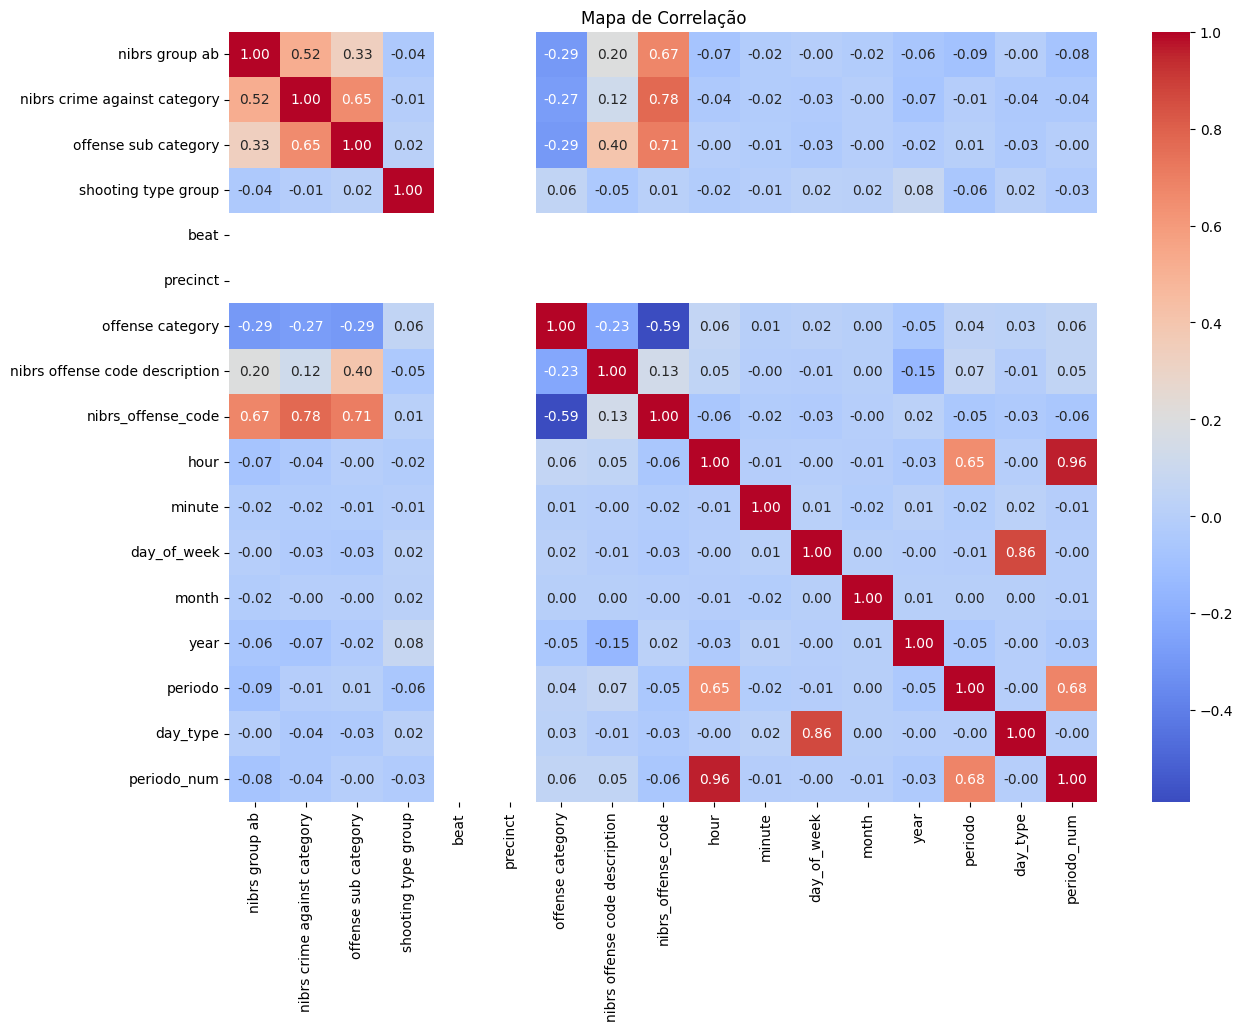

In [202]:
from sklearn.preprocessing import LabelEncoder



# Aplica LabelEncoder para colunas categóricas
le = LabelEncoder()
for col in df_corr.select_dtypes(include='object').columns:
    df_corr[col] = le.fit_transform(df_corr[col].astype(str))

# Agora todas as colunas são numéricas — podemos calcular a correlação
correlacao = df_corr.corr()

# Exibir com heatmap (opcional)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(correlacao, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mapa de Correlação")
plt.show()


In [203]:
# não existe correlações significativas entre as variáveis indicadas (crimes versus beat, hora do dia, período do dia).

### Formulação de hipóteses

#### O número de crimes em Seattle aumenta conforme a população cresce?

In [204]:
# De 2008 a 2024, os dados mostram uma tendência geral de queda na taxa de crimes por 100 mil habitantes na cidade de Seattle.

# No entanto, os crimes contra a pessoa apresentam uma tendência de alta, mantendo-se relativamente estáveis entre 2018 e 2023.
# Esse tipo de crime impacta diretamente o indivíduo e, por isso, tende a aumentar a percepção de insegurança na população.

#### Existe áreas específicas de Seattle onde a concentração de crimes é consistentemente maior?

In [205]:
# As regiões Norte e Oeste (North e West) são as que mais concentram registros de crimes, o que indica que podem ser consideradas as áreas mais perigosas da cidade.
# Por outro lado, a região Sudoeste (Southwest) foi a que apresentou o menor número de ocorrências, sendo a mais segura no período analisado.

# Entre as áreas de patrulhamento (beats), o setor K3, localizado na região Oeste (West), foi o que registrou o maior número de crimes.
# As outras áreas de patrulhamento R2, Q3, U3 e U1, completam as cinco mais perigosas.

#### Certas categorias de crime (propriedade, pessoa e sociedade) são mais frequentes?

In [206]:
# PROPERTY (67,8%) | propriedade
# Inclui crimes contra a propriedade, como furto, roubo, arrombamento e vandalismo. 
# A expressiva quantidade de ocorrências nessa categoria indica necessidade de medidas de prevenção específicas, como reforço na segurança (alarmes, câmeras, iluminação) e conscientização sobre proteção de bens.

# PERSON (16,1%) | pessoa
# Abrange crimes contra a pessoa, como agressão, homicídio e estupro. 
# Embora em menor número, têm grande impacto na segurança individual e coletiva, requerendo estratégias direcionadas de proteção e resposta imediata.

# SOCIETY (8,4%) | sociedade
# Envolve infrações que afetam a ordem pública e a coletividade, a exemplo de porte ilegal de arma, tráfico de drogas, prostituição e crimes ambientais. 
# Esse tipo de crime demanda políticas de controle social e intervenções específicas.

# ANY (7,6%) | qualquer
# Classificação genérica para casos em que não é possível determinar outro tipo de crime de forma mais precisa. 
# Esse percentual também pode indicar necessidade de aprimorar os métodos de registro e categorização.

#### Sazonalidade: Alguns meses ou períodos do ano registram mais crimes do que outros?

In [ ]:
# Não foram observadas variações significativas na distribuição dos dados ao longo dos meses do ano.

# Ao analisar a proporção de crimes por mês com value_counts(normalize=True), observamos que a variação entre o mês com mais ocorrências (maio – 8,8%) e o com menos (fevereiro – 7,4%) 
# é inferior a 2 pontos percentuais. Essa pequena diferença não é suficiente para indicar uma tendência sazonal significativa, 
# sugerindo uma distribuição relativamente homogênea ao longo do ano

#### Quais os tipos de crimes em destaque?

In [208]:
# ~43% dos crimes se dividem em LARCENY-THEFT (32.1%) e BURGLARY (10.8%).

# LARCENY-THEFT: corresponde a quase 1/3 de todos os registros. Isso reforça a ideia de que crimes contra a propriedade são comuns no dataset. 
## Inclui crimes de furto, geralmente sem uso de força ou violência direta contra a vítima (por exemplo, furtos em lojas, roubos de objetos em veículos destrancados, etc.).

# BURGLARY: corresponde a quase 11% dos casos, envolvendo invasão de imóveis (residências, estabelecimentos) para cometer furto ou outro delito. 
## Também se enquadra em crimes contra a propriedade.

#### Tendência de crimes ao longo do tempo

In [209]:
# Com base nos dados apresentados, nota-se um crescimento contínuo nos índices de crimes violentos, como AGGRAVATED ASSAULT, RAPE, Homicídios e KIDNAPPING/ABDUCTION, 
# bem como nos crimes contra a propriedade (especialmente BURGLARY, ARSON e MOTOR VEHICLE THEFT). 

# Além disso, o ano de 2020 se mostra atípico, com um aumento de 200% em fraudes e extorsões em comparação ao período anterior, 
# sugerindo forte influência das condições impostas pela pandemia. 

# Em conjunto, esses fatores indicam uma tendência preocupante de intensificação da criminalidade 
# e reforçam a necessidade de ações preventivas e de enfrentamento que considerem tanto os aspectos sociais e econômicos quanto a natureza específica de cada delito.

#### Sazonalidade e planejamento de recursos

In [210]:
# A grande maior parte dos crimes ocorrem entre 12h e 0h (tarde e noite). 
# Os crimes apresentam menor frequência na madrugada (0h - 6h) e pela manhã (6h - 12h).

# A distribuição de crimes para mês não apresenta diferenças que sejam expressivas para a análise.

In [211]:
dff_eda_freq_day_type = pd.merge((dff_eda.groupby(['offense sub category','day_type']).agg({'day_type':'count'}).rename({'day_type':'count_day_type'},axis=1). reset_index()), (dff_eda.groupby('offense sub category').agg({'offense id':'count'}).reset_index()), how='left', on='offense sub category')
dff_eda_freq_day_type['day_type_perc'] = round((dff_eda_freq_day_type['count_day_type'] / dff_eda_freq_day_type['offense id']), 2)

In [212]:
dff_eda_freq_day_type.head(2)

,offense sub category,day_type,count_day_type,offense id,day_type_perc
0,AGGRAVATED ASSAULT,business day,10587,19341,0.55
1,AGGRAVATED ASSAULT,weekend,8754,19341,0.45


In [213]:
dff_eda_freq_day_type[(dff_eda_freq_day_type['day_type']=='weekend') & (dff_eda_freq_day_type['day_type_perc']>0.5)]

,offense sub category,day_type,count_day_type,offense id,day_type_perc
13,DUI,weekend,4512,8374,0.54
17,GAMBLING OFFENSES,weekend,6,9,0.67
27,LIQUOR LAW VIOLATIONS & DRUNKENNESS,weekend,160,297,0.54


In [214]:
# # dias de semana (business day) tem uma ligeira quantidade maior de crimes do que nos finais de semana (weekend).
# apenas os crimes abaixo apresentam frequência maior nos finais de semana (weekend):
# DUI -> Dirigir Sob Influência: Condução de veículo sob efeito de álcool ou drogas.  
# GAMBLING OFFENSES -> Crimes Relacionados a Jogos de Azar: Apostas ilegais, cassinos não autorizados ou fraudes em jogos de azar. 
# LIQUOR LAW VIOLATIONS & DRUNKENNESS -> Violação de Leis de Álcool e Embriaguez Pública: Consumo, posse ou venda ilegal de bebidas alcoólicas, além de embriaguez em público.